In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import pipeline
from sklearn.preprocessing import RobustScaler,PowerTransformer,MinMaxScaler,StandardScaler
from sklearn.impute import SimpleImputer as Imputer

## BUILDING PIPELINE

In [2]:
num_pipeline=([('imputer',Imputer(strategy='mean')),('power_transformer',PowerTransformer()),
    ('min_max_scaler',MinMaxScaler()),('scaler',RobustScaler()),])

In [3]:
app_train = pd.read_csv('F:\\Downloads\\dseb-63-data-preparation-final-project\\dseb63_final_project_DP_dataset\\dseb63_application_train.csv')
app_train = app_train[['SK_ID_CURR','TARGET']]

In [4]:
pay = pd.read_csv('F:\\Downloads\\dseb-63-data-preparation-final-project\\dseb63_final_project_DP_dataset\\dseb63_installments_payments.csv')

In [5]:
pay.head()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0


In [6]:
pay_merged = pd.merge(pay,app_train,on='SK_ID_CURR',how='left')
pay_merged.head()

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR,TARGET
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0,0.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0,0.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0,0.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0,0.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0,0.0


In [7]:
pay

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0
...,...,...,...,...,...,...,...,...
7744753,2192667,1.0,6,-2352.0,-2352.0,5322.240,5322.240,21216.0
7744754,2208281,1.0,4,-452.0,-466.0,63195.435,63195.435,21216.0
7744755,2657771,0.0,3,-2907.0,-2932.0,3375.000,3375.000,21216.0
7744756,2657771,0.0,47,-1871.0,-1871.0,4915.890,4915.890,21216.0


## APPLYING FEATURES 

In [8]:
pay_merged['INSTALLMENTS_DAYS_365'] = [x if x >= -365 else np.nan for x in pay_merged.DAYS_ENTRY_PAYMENT]
pay_merged['INSTALLMENTS_DAYS_DIFF_LASTYR'] = pay_merged['DAYS_INSTALMENT'] - pay_merged['INSTALLMENTS_DAYS_365']
pay_merged.drop('INSTALLMENTS_DAYS_365', axis=1, inplace=True)

#### Calculating days over due

In [9]:
pay_merged['DPD'] = pay_merged['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']
pay_merged['DPD'] = pay_merged['DPD'].apply(lambda x: x if x > 0 else 0)

#### Calculating days before due

In [10]:
pay_merged['DBD'] = pay_merged['DAYS_INSTALMENT'] - pay_merged['DAYS_ENTRY_PAYMENT']
pay_merged['DBD'] = pay_merged['DBD'].apply(lambda x: x if x > 0 else 0)

#### FLAGGING ON TIME

In [11]:
pay_merged['ON_TIME_FLAG'] = pay_merged["DPD"].apply(lambda x: 1 if x == 0 else 0)

#### SUM ON TIME

In [12]:
pay_merged['ON_TIME_SUM'] = pay_merged.groupby(['SK_ID_CURR'])['ON_TIME_FLAG'].transform('sum')


#### PAYMENT COUNT

In [13]:
pay_merged['INS_COUNT'] = pay_merged.groupby(['SK_ID_CURR'])['ON_TIME_FLAG'].transform('count')

#### INSTALLMENT SUM 

In [14]:
pay_merged["INSTALMENT_SUM"] = pay_merged.groupby(["SK_ID_CURR"])["AMT_INSTALMENT"].transform("sum")

#### PAYMENT SUM

In [15]:
pay_merged["PAYMENT_SUM"] = pay_merged.groupby(["SK_ID_CURR"])["AMT_PAYMENT"].transform("sum")

In [16]:
# pay['DAYS_EARLY'] = pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']
# pay['AMT_COMPARE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT']
# pay = pay.drop(columns=['DAYS_INSTALMENT','AMT_INSTALMENT','SK_ID_PREV','SK_ID_CURR'])

In [17]:
pay_merged

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR,TARGET,INSTALLMENTS_DAYS_DIFF_LASTYR,DPD,DBD,ON_TIME_FLAG,ON_TIME_SUM,INS_COUNT,INSTALMENT_SUM,PAYMENT_SUM
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0,0.0,NaN,0.0,7.0,1,101.0,101.0,1272601.395,1272601.395
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0,0.0,NaN,0.0,6.0,1,101.0,101.0,1272601.395,1272601.395
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0,0.0,NaN,0.0,7.0,1,101.0,101.0,1272601.395,1272601.395
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0,0.0,3.0,0.0,3.0,1,101.0,101.0,1272601.395,1272601.395
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0,0.0,NaN,0.0,6.0,1,101.0,101.0,1272601.395,1272601.395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7744753,2192667,1.0,6,-2352.0,-2352.0,5322.240,5322.240,21216.0,0.0,NaN,0.0,0.0,1,106.0,106.0,2500805.385,2682491.715
7744754,2208281,1.0,4,-452.0,-466.0,63195.435,63195.435,21216.0,0.0,NaN,0.0,14.0,1,106.0,106.0,2500805.385,2682491.715
7744755,2657771,0.0,3,-2907.0,-2932.0,3375.000,3375.000,21216.0,0.0,NaN,0.0,25.0,1,106.0,106.0,2500805.385,2682491.715
7744756,2657771,0.0,47,-1871.0,-1871.0,4915.890,4915.890,21216.0,0.0,NaN,0.0,0.0,1,106.0,106.0,2500805.385,2682491.715


In [19]:
pay_final = pay_merged.groupby(['SK_ID_CURR']).agg({'ON_TIME_SUM': "first",
                                                    'INS_COUNT': "first",
                                                    'INSTALMENT_SUM': "first",
                                                    'PAYMENT_SUM': "first",
                                                    "DPD": ["sum", "mean"],
                                                    'INSTALLMENTS_DAYS_DIFF_LASTYR': ["first","sum","mean","min","max"]}).reset_index()
pay_final

SK_ID_CURR ON_TIME_SUM INS_COUNT INSTALMENT_SUM PAYMENT_SUM    DPD  \
                        first     first          first       first    sum   
0             0.0        30.0      30.0     310942.395  310942.395    0.0   
1             1.0        29.0      40.0     943344.765  787366.575   83.0   
2             3.0        43.0      43.0     244726.605  253501.605    0.0   
3             4.0         6.0       6.0      53721.135   53721.135    0.0   
4             5.0        10.0      10.0      98186.445   98186.445    0.0   
...           ...         ...       ...            ...         ...    ...   
180728   307501.0        33.0      33.0     311748.975  311748.975    0.0   
180729   307503.0        10.0      10.0      44943.930   44943.930    0.0   
180730   307504.0       120.0     133.0     241954.875  218359.305  260.0   
180731   307506.0        38.0      42.0     518373.360  518373.360   50.0   
180732   307508.0        42.0      52.0    1089214.830  936723.645   86.0   

                 INSTALLMENTS_DAYS_DIFF_LASTYR                                
            mean                         first    sum       mean   min   max  
0       0.000000                           0.0  117.0   4.500000   0.0  33.0  
1       2.075000                           0.0   -3.0  -0.230769  -6.0   1.0  
2       0.000000                           0.0  322.0   8.702703   0.0  99.0  
3       0.000000                           NaN    0.0        NaN   NaN   NaN  
4       0.000000                           NaN    0.0        NaN   NaN   NaN  
...          ...                           ...    ...        ...   ...   ...  
180728  0.000000                           NaN    0.0        NaN   NaN   NaN  
180729  0.000000                           NaN    0.0        NaN   NaN   NaN  
180730  1.954887                           0.0  127.0   7.937500   0.0  36.0  
180731  1.190476                          10.0  112.0  10.181818   6.0  13.0  
180732  1.653846                          25.0  376.0  23.500000  12.0  28.0  

[180733 rows x 12 columns]

#### ADDING PERCENT ON TIME

In [20]:
pay_final['ON_TIME_PERCENT'] = pay_final['ON_TIME_SUM'] / pay_final['INS_COUNT']
pay_final

SK_ID_CURR ON_TIME_SUM INS_COUNT INSTALMENT_SUM PAYMENT_SUM    DPD  \
                        first     first          first       first    sum   
0             0.0        30.0      30.0     310942.395  310942.395    0.0   
1             1.0        29.0      40.0     943344.765  787366.575   83.0   
2             3.0        43.0      43.0     244726.605  253501.605    0.0   
3             4.0         6.0       6.0      53721.135   53721.135    0.0   
4             5.0        10.0      10.0      98186.445   98186.445    0.0   
...           ...         ...       ...            ...         ...    ...   
180728   307501.0        33.0      33.0     311748.975  311748.975    0.0   
180729   307503.0        10.0      10.0      44943.930   44943.930    0.0   
180730   307504.0       120.0     133.0     241954.875  218359.305  260.0   
180731   307506.0        38.0      42.0     518373.360  518373.360   50.0   
180732   307508.0        42.0      52.0    1089214.830  936723.645   86.0   

                 INSTALLMENTS_DAYS_DIFF_LASTYR                                \
            mean                         first    sum       mean   min   max   
0       0.000000                           0.0  117.0   4.500000   0.0  33.0   
1       2.075000                           0.0   -3.0  -0.230769  -6.0   1.0   
2       0.000000                           0.0  322.0   8.702703   0.0  99.0   
3       0.000000                           NaN    0.0        NaN   NaN   NaN   
4       0.000000                           NaN    0.0        NaN   NaN   NaN   
...          ...                           ...    ...        ...   ...   ...   
180728  0.000000                           NaN    0.0        NaN   NaN   NaN   
180729  0.000000                           NaN    0.0        NaN   NaN   NaN   
180730  1.954887                           0.0  127.0   7.937500   0.0  36.0   
180731  1.190476                          10.0  112.0  10.181818   6.0  13.0   
180732  1.653846                          25.0  376.0  23.500000  12.0  28.0   

       ON_TIME_PERCENT  
                        
0             1.000000  
1             0.725000  
2             1.000000  
3             1.000000  
4             1.000000  
...                ...  
180728        1.000000  
180729        1.000000  
180730        0.902256  
180731        0.904762  
180732        0.807692  

[180733 rows x 13 columns]

#### ADDING PAYMENT/INSTALLMENT RATIO

In [21]:
pay_final['PAYS_TO_INS'] = pay_final['PAYMENT_SUM'] / pay_final['INSTALMENT_SUM']
pay_final

SK_ID_CURR ON_TIME_SUM INS_COUNT INSTALMENT_SUM PAYMENT_SUM    DPD  \
                        first     first          first       first    sum   
0             0.0        30.0      30.0     310942.395  310942.395    0.0   
1             1.0        29.0      40.0     943344.765  787366.575   83.0   
2             3.0        43.0      43.0     244726.605  253501.605    0.0   
3             4.0         6.0       6.0      53721.135   53721.135    0.0   
4             5.0        10.0      10.0      98186.445   98186.445    0.0   
...           ...         ...       ...            ...         ...    ...   
180728   307501.0        33.0      33.0     311748.975  311748.975    0.0   
180729   307503.0        10.0      10.0      44943.930   44943.930    0.0   
180730   307504.0       120.0     133.0     241954.875  218359.305  260.0   
180731   307506.0        38.0      42.0     518373.360  518373.360   50.0   
180732   307508.0        42.0      52.0    1089214.830  936723.645   86.0   

                 INSTALLMENTS_DAYS_DIFF_LASTYR                                \
            mean                         first    sum       mean   min   max   
0       0.000000                           0.0  117.0   4.500000   0.0  33.0   
1       2.075000                           0.0   -3.0  -0.230769  -6.0   1.0   
2       0.000000                           0.0  322.0   8.702703   0.0  99.0   
3       0.000000                           NaN    0.0        NaN   NaN   NaN   
4       0.000000                           NaN    0.0        NaN   NaN   NaN   
...          ...                           ...    ...        ...   ...   ...   
180728  0.000000                           NaN    0.0        NaN   NaN   NaN   
180729  0.000000                           NaN    0.0        NaN   NaN   NaN   
180730  1.954887                           0.0  127.0   7.937500   0.0  36.0   
180731  1.190476                          10.0  112.0  10.181818   6.0  13.0   
180732  1.653846                          25.0  376.0  23.500000  12.0  28.0   

       ON_TIME_PERCENT PAYS_TO_INS  
                                    
0             1.000000    1.000000  
1             0.725000    0.834654  
2             1.000000    1.035856  
3             1.000000    1.000000  
4             1.000000    1.000000  
...                ...         ...  
180728        1.000000    1.000000  
180729        1.000000    1.000000  
180730        0.902256    0.902479  
180731        0.904762    1.000000  
180732        0.807692    0.859999  

[180733 rows x 14 columns]

#### CATEGORIZE EACH ID BASED ON ON TIME PAYMENT_TO_INSTALLMENT RATIO

In [22]:
def category(x):
    if x >= 0.89:
        return 'Good'
    elif x >= 0.83:
        return 'Par'
    elif x >= 0.71:
        return 'Sub_Par'
    elif x >= 0.53:
        return 'Poor'
    else:
        return 'Very_Poor'

#### APPLYING CATEGORICAL GRADING ON 'ON TIME RATE'

In [23]:
pay_final['INS_ON_TIME_GRADE'] = pay_final['ON_TIME_PERCENT'].apply(category)
pay_final

SK_ID_CURR ON_TIME_SUM INS_COUNT INSTALMENT_SUM PAYMENT_SUM    DPD  \
                        first     first          first       first    sum   
0             0.0        30.0      30.0     310942.395  310942.395    0.0   
1             1.0        29.0      40.0     943344.765  787366.575   83.0   
2             3.0        43.0      43.0     244726.605  253501.605    0.0   
3             4.0         6.0       6.0      53721.135   53721.135    0.0   
4             5.0        10.0      10.0      98186.445   98186.445    0.0   
...           ...         ...       ...            ...         ...    ...   
180728   307501.0        33.0      33.0     311748.975  311748.975    0.0   
180729   307503.0        10.0      10.0      44943.930   44943.930    0.0   
180730   307504.0       120.0     133.0     241954.875  218359.305  260.0   
180731   307506.0        38.0      42.0     518373.360  518373.360   50.0   
180732   307508.0        42.0      52.0    1089214.830  936723.645   86.0   

                 INSTALLMENTS_DAYS_DIFF_LASTYR                                \
            mean                         first    sum       mean   min   max   
0       0.000000                           0.0  117.0   4.500000   0.0  33.0   
1       2.075000                           0.0   -3.0  -0.230769  -6.0   1.0   
2       0.000000                           0.0  322.0   8.702703   0.0  99.0   
3       0.000000                           NaN    0.0        NaN   NaN   NaN   
4       0.000000                           NaN    0.0        NaN   NaN   NaN   
...          ...                           ...    ...        ...   ...   ...   
180728  0.000000                           NaN    0.0        NaN   NaN   NaN   
180729  0.000000                           NaN    0.0        NaN   NaN   NaN   
180730  1.954887                           0.0  127.0   7.937500   0.0  36.0   
180731  1.190476                          10.0  112.0  10.181818   6.0  13.0   
180732  1.653846                          25.0  376.0  23.500000  12.0  28.0   

       ON_TIME_PERCENT PAYS_TO_INS INS_ON_TIME_GRADE  
                                                      
0             1.000000    1.000000              Good  
1             0.725000    0.834654           Sub_Par  
2             1.000000    1.035856              Good  
3             1.000000    1.000000              Good  
4             1.000000    1.000000              Good  
...                ...         ...               ...  
180728        1.000000    1.000000              Good  
180729        1.000000    1.000000              Good  
180730        0.902256    0.902479              Good  
180731        0.904762    1.000000              Good  
180732        0.807692    0.859999           Sub_Par  

[180733 rows x 15 columns]

#### APPLYING CATEGORICAL GRADING ON 'PAYMENT/INSTALLMENT RATE'

In [24]:
pay_final['PAYMENT_GRADE'] = pay_final['PAYS_TO_INS'].apply(category)
pay_final

SK_ID_CURR ON_TIME_SUM INS_COUNT INSTALMENT_SUM PAYMENT_SUM    DPD  \
                        first     first          first       first    sum   
0             0.0        30.0      30.0     310942.395  310942.395    0.0   
1             1.0        29.0      40.0     943344.765  787366.575   83.0   
2             3.0        43.0      43.0     244726.605  253501.605    0.0   
3             4.0         6.0       6.0      53721.135   53721.135    0.0   
4             5.0        10.0      10.0      98186.445   98186.445    0.0   
...           ...         ...       ...            ...         ...    ...   
180728   307501.0        33.0      33.0     311748.975  311748.975    0.0   
180729   307503.0        10.0      10.0      44943.930   44943.930    0.0   
180730   307504.0       120.0     133.0     241954.875  218359.305  260.0   
180731   307506.0        38.0      42.0     518373.360  518373.360   50.0   
180732   307508.0        42.0      52.0    1089214.830  936723.645   86.0   

                 INSTALLMENTS_DAYS_DIFF_LASTYR                                \
            mean                         first    sum       mean   min   max   
0       0.000000                           0.0  117.0   4.500000   0.0  33.0   
1       2.075000                           0.0   -3.0  -0.230769  -6.0   1.0   
2       0.000000                           0.0  322.0   8.702703   0.0  99.0   
3       0.000000                           NaN    0.0        NaN   NaN   NaN   
4       0.000000                           NaN    0.0        NaN   NaN   NaN   
...          ...                           ...    ...        ...   ...   ...   
180728  0.000000                           NaN    0.0        NaN   NaN   NaN   
180729  0.000000                           NaN    0.0        NaN   NaN   NaN   
180730  1.954887                           0.0  127.0   7.937500   0.0  36.0   
180731  1.190476                          10.0  112.0  10.181818   6.0  13.0   
180732  1.653846                          25.0  376.0  23.500000  12.0  28.0   

       ON_TIME_PERCENT PAYS_TO_INS INS_ON_TIME_GRADE PAYMENT_GRADE  
                                                                    
0             1.000000    1.000000              Good          Good  
1             0.725000    0.834654           Sub_Par           Par  
2             1.000000    1.035856              Good          Good  
3             1.000000    1.000000              Good          Good  
4             1.000000    1.000000              Good          Good  
...                ...         ...               ...           ...  
180728        1.000000    1.000000              Good          Good  
180729        1.000000    1.000000              Good          Good  
180730        0.902256    0.902479              Good          Good  
180731        0.904762    1.000000              Good          Good  
180732        0.807692    0.859999           Sub_Par           Par  

[180733 rows x 16 columns]

In [25]:
pay_final.columns = ['_'.join(col).strip().upper() for col in pay_final.columns.values]

In [26]:
pay_final

,SK_ID_CURR_,ON_TIME_SUM_FIRST,INS_COUNT_FIRST,INSTALMENT_SUM_FIRST,PAYMENT_SUM_FIRST,DPD_SUM,DPD_MEAN,INSTALLMENTS_DAYS_DIFF_LASTYR_FIRST,INSTALLMENTS_DAYS_DIFF_LASTYR_SUM,INSTALLMENTS_DAYS_DIFF_LASTYR_MEAN,INSTALLMENTS_DAYS_DIFF_LASTYR_MIN,INSTALLMENTS_DAYS_DIFF_LASTYR_MAX,ON_TIME_PERCENT_,PAYS_TO_INS_,INS_ON_TIME_GRADE_,PAYMENT_GRADE_
0,0.0,30.0,30.0,310942.395,310942.395,0.0,0.000000,0.0,117.0,4.500000,0.0,33.0,1.000000,1.000000,Good,Good
1,1.0,29.0,40.0,943344.765,787366.575,83.0,2.075000,0.0,-3.0,-0.230769,-6.0,1.0,0.725000,0.834654,Sub_Par,Par
2,3.0,43.0,43.0,244726.605,253501.605,0.0,0.000000,0.0,322.0,8.702703,0.0,99.0,1.000000,1.035856,Good,Good
3,4.0,6.0,6.0,53721.135,53721.135,0.0,0.000000,NaN,0.0,NaN,NaN,NaN,1.000000,1.000000,Good,Good
4,5.0,10.0,10.0,98186.445,98186.445,0.0,0.000000,NaN,0.0,NaN,NaN,NaN,1.000000,1.000000,Good,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180728,307501.0,33.0,33.0,311748.975,311748.975,0.0,0.000000,NaN,0.0,NaN,NaN,NaN,1.000000,1.000000,Good,Good
180729,307503.0,10.0,10.0,44943.930,44943.930,0.0,0.000000,NaN,0.0,NaN,NaN,NaN,1.000000,1.000000,Good,Good
180730,307504.0,120.0,133.0,241954.875,218359.305,260.0,1.954887,0.0,127.0,7.937500,0.0,36.0,0.902256,0.902479,Good,Good
180731,307506.0,38.0,42.0,518373.360,518373.360,50.0,1.190476,10.0,112.0,10.181818,6.0,13.0,0.904762,1.000000,Good,Good


In [27]:
pay_final.to_csv("F:\\Downloads\\git\\installments_payments_final.csv")

## APPLYING PIPELINE

In [ ]:
new_pay = pd.DataFrame(pipeline.Pipeline(num_pipeline).fit_transform(pay))

### CHECKING NULL VALUES

In [ ]:
check_null = new_pay.isna().sum().sort_values(ascending=False)
percentage = ((new_pay.isnull().sum()/len(pay)*100)).sort_values(ascending=False)
null_cols = pd.concat([check_null, percentage], axis=1, keys=['Count','Percentage'])
print('Distributions of Missing values:')
null_cols.head(20)

Distributions of Missing values:


,Count,Percentage
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0


In [ ]:
new_pay

,0,1,2,3,4,5,6,7
0,-0.984214,0.0,-0.250920,-0.241269,-0.240537,-0.151364,-0.084086,-0.036637
1,0.565103,0.0,0.495535,0.266280,0.269991,0.201054,0.242658,-0.036637
2,-0.984214,0.0,-0.923235,-0.316621,-0.316116,-0.151364,-0.084086,-0.036637
3,-0.231558,0.0,-0.923235,0.662259,0.672770,-0.110022,-0.045717,-0.036637
4,0.565103,0.0,0.064099,-0.026672,-0.024404,0.201054,0.242658,-0.036637
...,...,...,...,...,...,...,...,...
7744753,0.307602,0.0,-0.250920,-0.845958,-0.843363,-0.330759,-0.250702,-1.046924
7744754,0.323350,0.0,-0.504465,0.368955,0.363923,1.753994,1.674889,-1.046924
7744755,0.761151,-1.0,-0.682190,-1.067025,-1.074117,-0.616461,-0.516491,-1.046924
7744756,0.761151,-1.0,0.915208,-0.626983,-0.623725,-0.382420,-0.298722,-1.046924


### CHECKING OUTLIERS

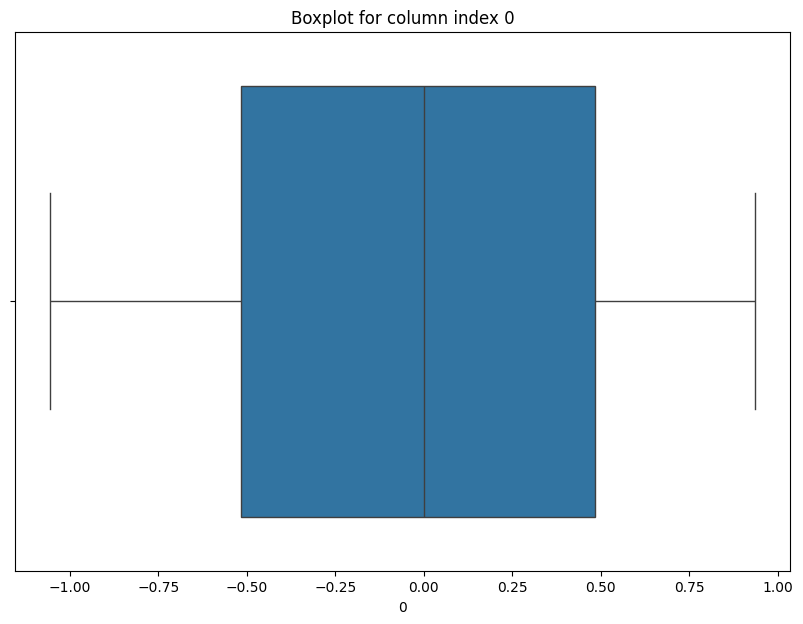

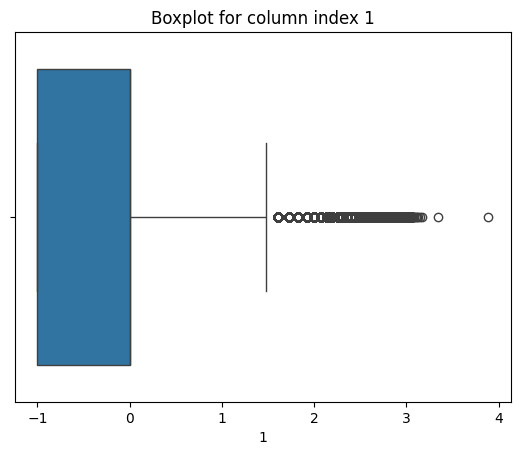

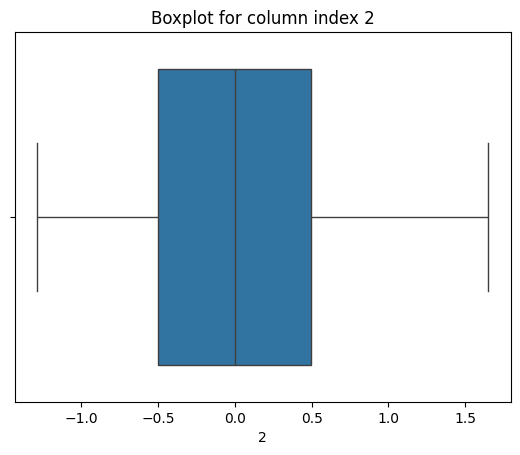

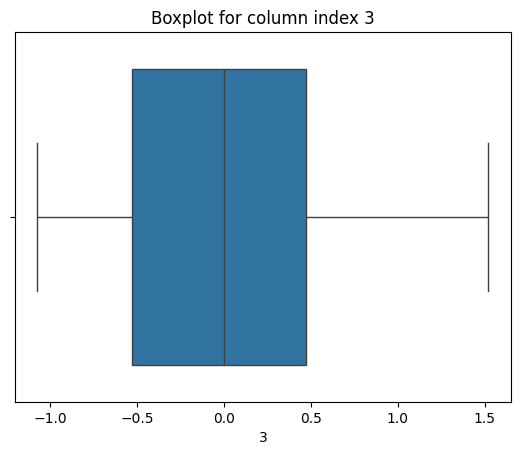

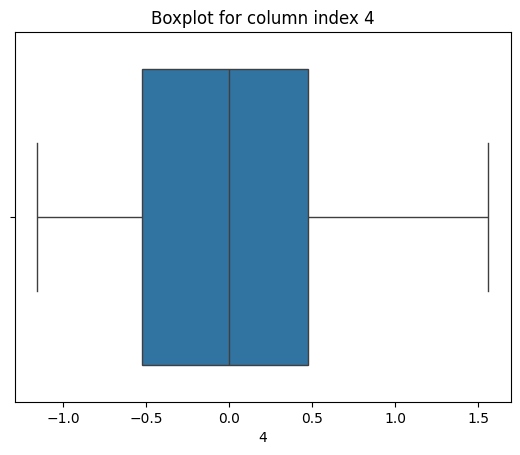

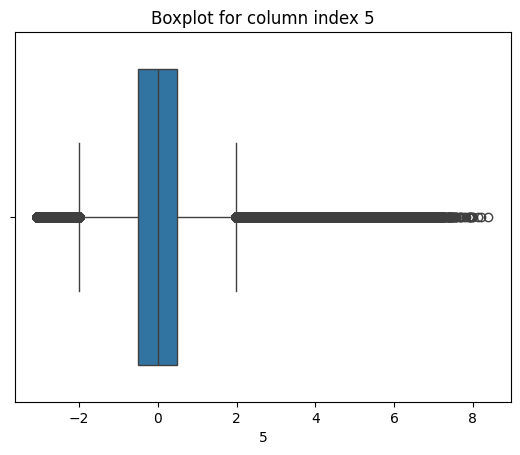

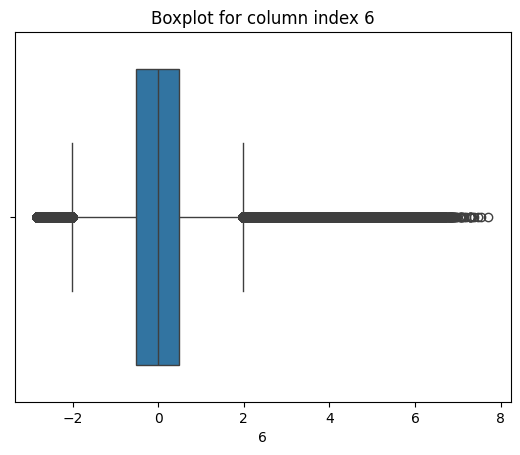

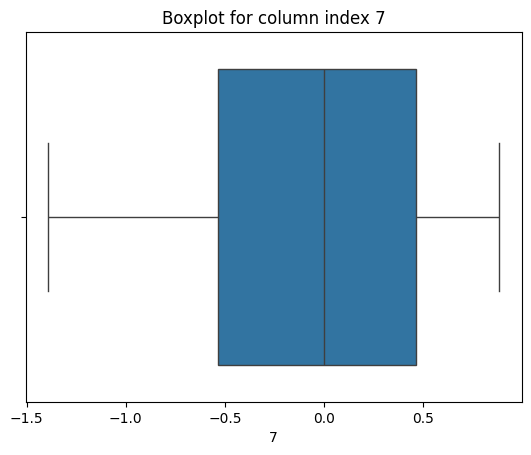

In [ ]:
plt.figure(figsize=(10, 7))

for column in new_pay.columns:
    sns.boxplot(x=new_pay[column])

    plt.title(f'Boxplot for column index {column}')

    plt.show()